Find the expected value of getting 2 limited 5 star characters. We know probability of all 4 cases: WW, WLW, LWW, LWLW are 0.25. Expected value of getting just one 5 star is 62.5 pulls. 1 pull is 160 gems so we know the cost for each case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pandas as pd

# This is just me having fun with statistics - not that useful - skip to below!

In [2]:
gem_cost = 160
ev_5 = 62.5
gem_map = {
    0: 2 * ev_5 * gem_cost,
    1: 3 * ev_5 * gem_cost,
    2: 3 * ev_5 * gem_cost,
    3: 4 * ev_5 * gem_cost
}
rng = np.random.default_rng()

def simulation(M, N): 
    sim = rng.integers(4, size=(M, N))
    cost = np.vectorize(gem_map.get)(sim)
    return cost

In [3]:
M, N = 2000, 50
samples = simulation(M, N)

In [4]:
means = np.mean(samples, axis=1)
samples = samples.flatten()

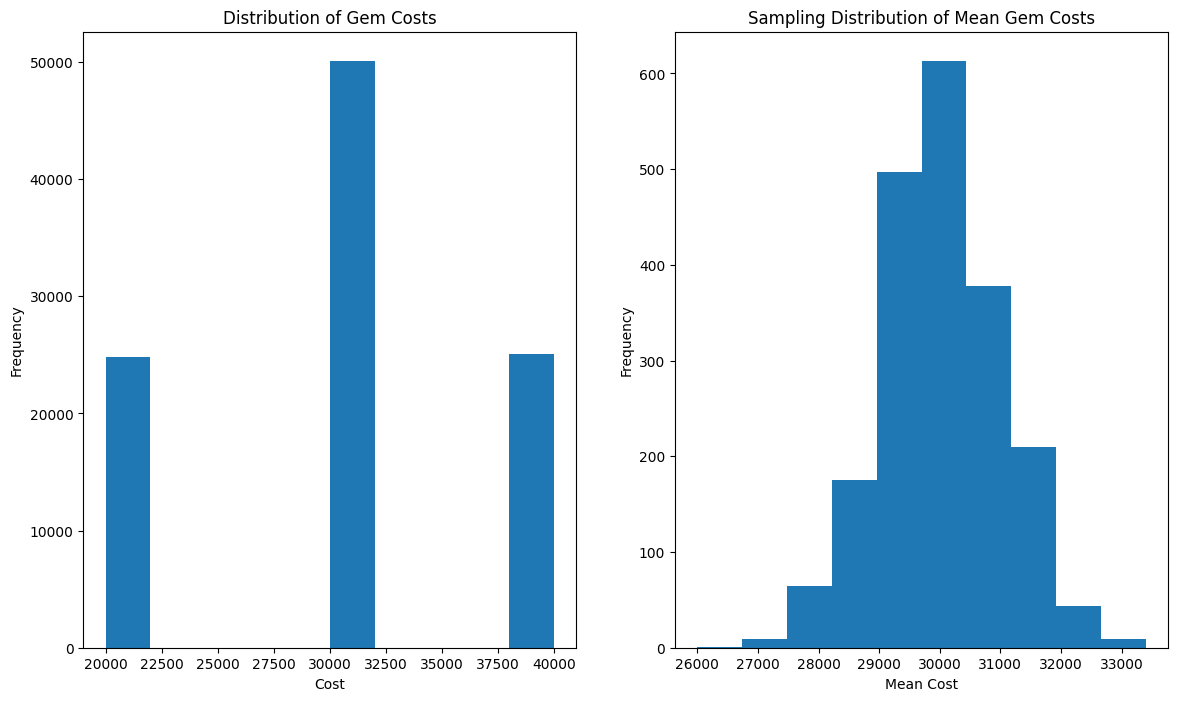

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

axs[0].hist(samples)
axs[0].set_title('Distribution of Gem Costs')
axs[0].set(xlabel='Cost', ylabel='Frequency')
axs[1].hist(means)
axs[1].set_title('Sampling Distribution of Mean Gem Costs')
axs[1].set(xlabel='Mean Cost', ylabel='Frequency')
plt.show()

In [6]:
ss.describe(samples)

DescribeResult(nobs=100000, minmax=(20000.0, 40000.0), mean=30027.3, variance=49918753.89753895, skewness=-0.0038513654940911727, kurtosis=-0.996724979839819)

In [7]:
ss.describe(means)

DescribeResult(nobs=2000, minmax=(26000.0, 33400.0), mean=30027.3, variance=950549.9849924963, skewness=0.005637393641109189, kurtosis=0.11564077071830958)

We know means follows a normal distribution since it is a sampling distribution of a mean, ie. the central limit theorem. Based on calculations, we actually know that the $\mu_X=30000$ and the $\sigma_X=7071.04$. So then the sampling distribution is a normal distribution with $mu_{\bar{X}}=30000, \sigma_{\bar{X}}=7071.04/(M*N)$. But for the sake of this, let's pretend that we didn't know the true distribution and it had to be estimated.

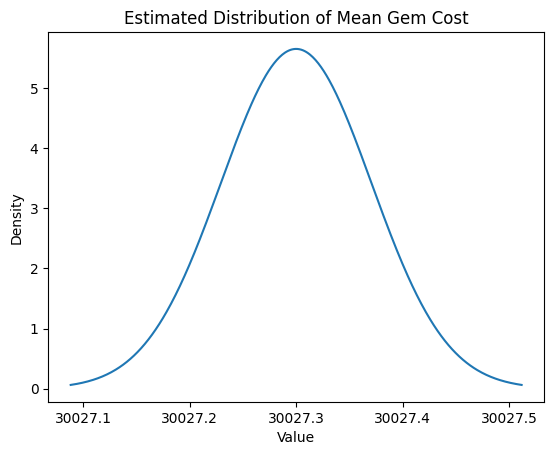

In [8]:
mu = samples.mean()
std = samples.std() / (M * N)
x = np.linspace(mu-3*std, mu+3*std, 500)
plt.plot(x, ss.norm.pdf(x, loc=mu, scale=std))
plt.title('Estimated Distribution of Mean Gem Cost')
plt.ylabel('Density')
plt.xlabel('Value')
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

We can try to fit a distribution onto the histogram, but it's not likely to end well.

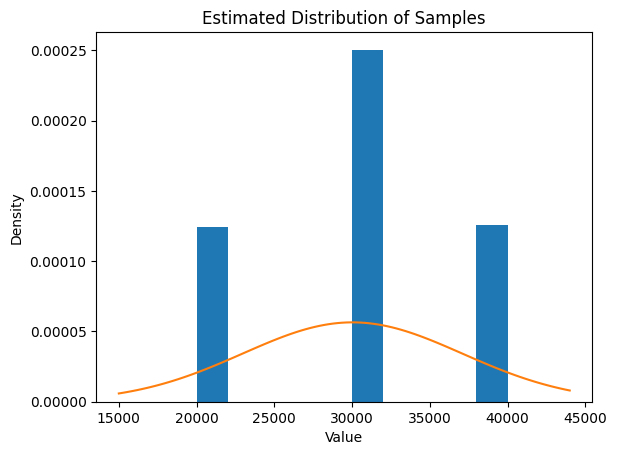

In [9]:
mu, std = ss.norm.fit(samples)
plt.hist(samples, density=True)
x = np.linspace(15000, 44000, 100)
p = ss.norm.pdf(x, mu, std)
plt.plot(x, p)
plt.title('Estimated Distribution of Samples')
plt.ylabel('Density')
plt.xlabel('Value')
plt.show()

Terrible fit as expected - let's try to do something more reasonable.

# Good stuff

Now let's make some assumptions. We know that the chance of a 5 star unit is 0.6%, but once you hit are on pull 74, then it starts increasing. We don't know by how much, but we'll assume it increases linearly. 

In [10]:
def wish():
    wishes = []
    limited = 0
    soft_pity_thresh = 73
    guarantee = 90
    five_star_map = {0: 'Not 5 Star', 1: '5 Star'}
    five_star_rate = 0.006
    fiftyfifty_map = {0: 'Standard', 1: 'Limited'}
    prob_increase = (1 - five_star_rate) / (guarantee - soft_pity_thresh)
    last_five_star = 'Limited' # tracks 50/50, start with last one being limited
    while limited < 2:
        five_star = False
        count = 0
        while not five_star:
            wish = rng.binomial(1, five_star_rate + prob_increase * max(count - soft_pity_thresh, 0))
            rarity = five_star_map[wish]
            if rarity == '5 Star':
                if last_five_star == 'Limited':
                    wish = rng.binomial(1, 0.5)
                else:
                    wish = 1
                rarity = fiftyfifty_map[wish]
                last_five_star = rarity
                limited += wish
                five_star = True
            count += 1
        wishes.append(count)
    return sum(wishes)

def sim_two_limited(M):
    results = []
    for i in range(M):
        results.append(wish())
    return results

In [11]:
results = np.array(sim_two_limited(10000))

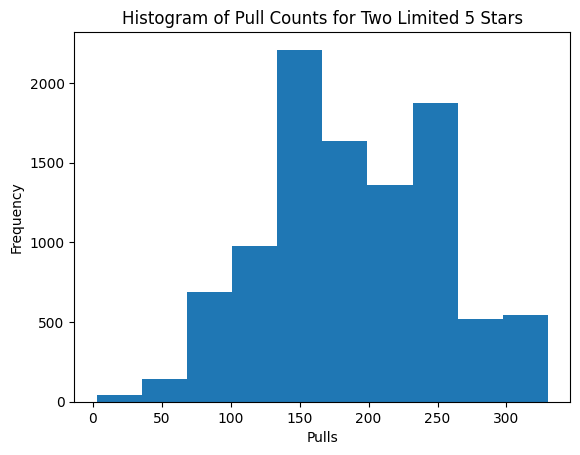

In [12]:
plt.hist(results)
plt.title('Histogram of Pull Counts for Two Limited 5 Stars')
plt.xlabel('Pulls')
plt.ylabel('Frequency')
plt.show()

In [13]:
results.mean(), results.mean() * gem_cost

(188.7265, 30196.239999999998)

In [14]:
results.std(), results.std() * gem_cost

(61.560017038253, 9849.60272612048)

In [15]:
probabilities = np.linspace(0, 1, 11)
percentiles = np.quantile(results, probabilities)
gem_percentiles = gem_cost * percentiles
df = pd.DataFrame(data={'Pull Percentile': percentiles, 'Gem Percentiles': gem_percentiles})
df.index = probabilities
df.index.name = 'Probabilities'
df

,Pull Percentile,Gem Percentiles
Probabilities,,
0.0,3.0,480.0
0.1,106.0,16960.0
0.2,138.0,22080.0
0.3,157.0,25120.0
0.4,165.0,26400.0
0.5,184.0,29440.0
0.6,207.0,33120.0
0.7,231.0,36960.0
0.8,238.0,38080.0


The only real thing we know is that the actual mean is 187.5, so this has a reasonable chance of matching up - it's unlikely for them to do something more complicated for soft pity. So assuming that we are not the bottom 30% of luck, we'd need under 231 pulls, or 37k gems.